In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [8]:
data_path = 'data/201709-202201_15min.csv'

data = pd.read_csv(data_path)
data = data.drop(['timestamp'], axis=1)[3:]

data.head()

,price_open,price_high,price_low,price_close,volume_traded,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
3,4761.78,4765.21,4750.00,4763.99,80.947865,2.801405,4747.140,172.423304,56.673126,41.091393,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4764.00,4777.76,4760.01,4776.64,122.945495,3.810522,4755.616,295.368800,60.346682,64.587022,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,4776.64,4776.65,4756.79,4775.96,63.997143,3.756277,4762.608,231.371656,61.689952,42.559361,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,4765.02,4775.99,4763.00,4770.78,30.231978,3.343058,4768.846,201.139678,60.265506,49.642207,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,4770.78,4776.17,4763.01,4771.30,33.774459,3.384539,4771.734,234.914137,58.694009,52.946271,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'vader_compound',	'pos_count', 'neg_count', 'neu_count'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))

In [10]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

window_size = 5

feature, label = split_data(feature, label, window_size)

train_size = int(0.8 * len(label))

X_train, X_test = feature[:train_size], feature[train_size:]
y_train, y_test = label[:train_size], label[train_size:]

print(X_train.shape, X_test.shape)

(95840, 5, 11) (23960, 5, 11)


In [11]:
# split train X data into 5 datasets
newarr = np.array_split(X_train, 5)
X_train_1 = newarr[0] 
X_train_2 = newarr[1]
X_train_3 = newarr[2]
X_train_4 = newarr[3]
X_train_5 = newarr[4]

# split train y data into 5 datasets
newarr_y = np.array_split(y_train, 5)
y_train_1 = newarr_y[0] 
y_train_2 = newarr_y[1]
y_train_3 = newarr_y[2]
y_train_4 = newarr_y[3]
y_train_5 = newarr_y[4]

In [12]:
# Train dataset 1 （1-4）
X_train_dataset_1 = X_train_1+X_train_2+X_train_3+X_train_4

# Train dataset 2 （1-3，5）
X_train_dataset_2 = X_train_1+X_train_2+X_train_3+X_train_5

# Train dataset 3 （1，2，4，5）
X_train_dataset_3 = X_train_1+X_train_2+X_train_4+X_train_5

# Train dataset 4 （1，3-5）
X_train_dataset_4 = X_train_1+X_train_3+X_train_4+X_train_5

# Train dataset 5 （2-5）
X_train_dataset_5 = X_train_2+X_train_3+X_train_4+X_train_5

In [13]:
# Test dataset 1 （1-4）
y_train_dataset_1 = y_train_1+y_train_2+y_train_3+y_train_4

# Test dataset 2 （1-3，5）
y_train_dataset_2 = y_train_1+y_train_2+y_train_3+y_train_5

# Test dataset 3 （1，2，4，5）
y_train_dataset_3 = y_train_1+y_train_2+y_train_4+y_train_5

# Test dataset 4 （1，3-5）
y_train_dataset_4 = y_train_1+y_train_3+y_train_4+y_train_5

# Test dataset 5 （2-5）
y_train_dataset_5 = y_train_2+y_train_3+y_train_4+y_train_5

In [14]:
X_train_datasets = [X_train_dataset_1,X_train_dataset_2,X_train_dataset_3,X_train_dataset_4,X_train_dataset_5]
y_train_datasets = [y_train_dataset_1,y_train_dataset_2,y_train_dataset_3,y_train_dataset_4,y_train_dataset_5]

# Base Models

In [15]:
nGRU = 5
nLSTM = 5

In [16]:
GRUs = [
    keras.Sequential([
        layers.GRU(2048),
        layers.Dense(1024),
        layers.Dense(1)
    ]) for i in range(nGRU)
]


LSTMs = [
    keras.Sequential([
        layers.SimpleRNN(512),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nLSTM)
]

2022-11-02 01:24:07.428426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 01:24:07.436401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 01:24:07.436633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 01:24:07.437331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
for model, X, y in zip(GRUs, X_train_datasets, y_train_datasets):
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                metrics=[keras.metrics.RootMeanSquaredError()]
                )
    history = model.fit(X, y,
                        epochs=30,
                        batch_size=4,
                        shuffle=True
                        )


/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-11-02 01:24:08.033476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-02 01:24:13.382374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


4792/4792 [==============================] - 40s 7ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 2/30
4792/4792 [==============================] - 35s 7ms/step - loss: 1.7868e-04 - root_mean_squared_error: 0.0134
Epoch 3/30
4792/4792 [==============================] - 35s 7ms/step - loss: 8.0912e-05 - root_mean_squared_error: 0.0090
Epoch 4/30
4792/4792 [==============================] - 35s 7ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482
Epoch 5/30
4792/4792 [==============================] - 35s 7ms/step - loss: 4.7072e-05 - root_mean_squared_error: 0.0069
Epoch 6/30
4792/4792 [==============================] - 35s 7ms/step - loss: 2.5981e-05 - root_mean_squared_error: 0.0051
Epoch 7/30
4792/4792 [==============================] - 35s 7ms/step - loss: 1.5347e-05 - root_mean_squared_error: 0.0039
Epoch 8/30
4792/4792 [==============================] - 35s 7ms/step - loss: 1.0450e-05 - root_mean_squared_error: 0.0032
Epoch 9/30
4792/4792 [=====================

In [18]:
for model, X, y in zip(LSTMs, X_train_datasets, y_train_datasets):
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(X, y, 
                        batch_size=16, 
                        epochs=50, 
                        shuffle=False,
                        )

Epoch 1/50
1198/1198 [==============================] - 3s 2ms/step - loss: 0.1154 - root_mean_squared_error: 0.3397
Epoch 2/50
1198/1198 [==============================] - 2s 2ms/step - loss: 8.6910e-04 - root_mean_squared_error: 0.0295
Epoch 3/50
1198/1198 [==============================] - 2s 2ms/step - loss: 5.6184e-04 - root_mean_squared_error: 0.0237
Epoch 4/50
1198/1198 [==============================] - 2s 2ms/step - loss: 3.3661e-04 - root_mean_squared_error: 0.0183
Epoch 5/50
1198/1198 [==============================] - 2s 2ms/step - loss: 3.4603e-04 - root_mean_squared_error: 0.0186
Epoch 6/50
1198/1198 [==============================] - 2s 2ms/step - loss: 2.7210e-04 - root_mean_squared_error: 0.0165
Epoch 7/50
1198/1198 [==============================] - 2s 2ms/step - loss: 3.4327e-04 - root_mean_squared_error: 0.0185
Epoch 8/50
1198/1198 [==============================] - 2s 2ms/step - loss: 3.0816e-04 - root_mean_squared_error: 0.0176
Epoch 9/50
1198/1198 [==============

In [19]:
pred_GRU = []
pred_LSTM = []
for gru, lstm, data in zip(GRUs, LSTMs, newarr[::-1]):
    pred_GRU = gru.predict(data).tolist() + pred_GRU
    pred_LSTM = lstm.predict(data).tolist() + pred_LSTM
    
pred_GRU = np.array(pred_GRU)
pred_LSTM = np.array(pred_LSTM)

X_tmp = np.concatenate((pred_GRU, pred_LSTM), axis=1)

In [20]:
pred_prices = scaler_label.inverse_transform(np.mean(np.array(pred_GRU), axis=1).reshape(-1, 1))
true_prices = scaler_label.inverse_transform(y_train.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

print(mse, rmse, mae)

pred_prices = scaler_label.inverse_transform(np.mean(np.array(pred_LSTM), axis=1).reshape(-1, 1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

print(mse, rmse, mae)

40291907.026791856 6347.590647386759 6023.359502322788
202631956.00615287 14234.88517713272 13713.15267625975


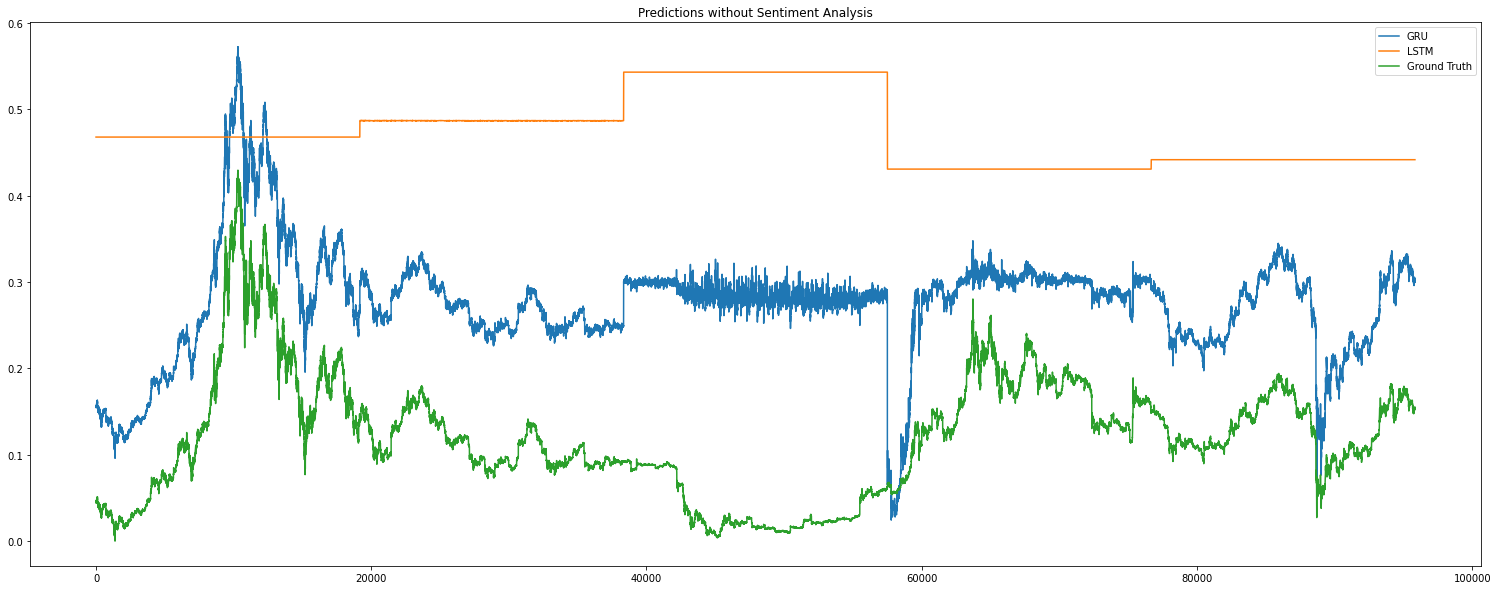

In [21]:
plt.figure(figsize=(26, 10))

plt.plot(pred_GRU, label='GRU')
plt.plot(pred_LSTM, label='LSTM')
plt.plot(y_train, label='Ground Truth')
plt.legend()
plt.title('Predictions without Sentiment Analysis')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.show()

# MLP

In [25]:
batch_size = 8
model = Sequential([Dense(1)])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(X_tmp, y_train, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
11980/11980 [==============================] - 7s 579us/step - loss: 0.0095 - accuracy: 1.0434e-05
Epoch 2/50
11980/11980 [==============================] - 7s 577us/step - loss: 0.0011 - accuracy: 1.0434e-05
Epoch 3/50
11980/11980 [==============================] - 7s 576us/step - loss: 6.2503e-04 - accuracy: 1.0434e-05
Epoch 4/50
11980/11980 [==============================] - 7s 584us/step - loss: 5.8943e-04 - accuracy: 1.0434e-05
Epoch 5/50
11980/11980 [==============================] - 7s 577us/step - loss: 5.8852e-04 - accuracy: 1.0434e-05
Epoch 6/50
11980/11980 [==============================] - 7s 576us/step - loss: 5.8859e-04 - accuracy: 1.0434e-05
Epoch 7/50
11980/11980 [==============================] - 7s 577us/step - loss: 5.8830e-04 - accuracy: 1.0434e-05
Epoch 8/50
11980/11980 [==============================] - 7s 583us/step - loss: 5.8826e-04 - accuracy: 1.0434e-05
Epoch 9/50
11980/11980 [==============================] - 7s 578us/step - loss: 5.8853e-04 - acc

In [26]:
pred_GRU = [model.predict(X_test) for model in GRUs]
pred_LSTM = [model.predict(X_test) for model in LSTMs]

pred_GRU = np.mean(np.array(pred_GRU), axis=0)
pred_LSTM = np.mean(np.array(pred_LSTM), axis=0)

X_tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=1).squeeze()

prediction = model.predict(X_tmp2)

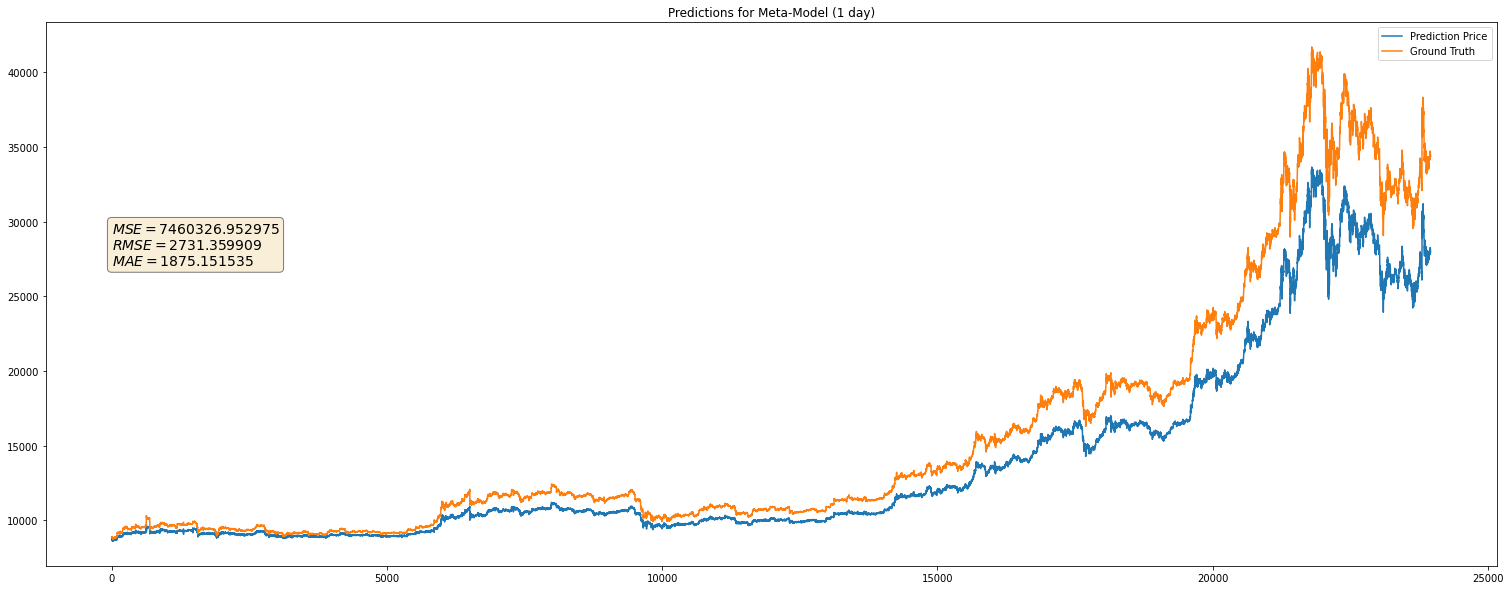

In [27]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()